# Quarter 2: Project

The main deliverable for the second quarter of the computational economics and finance class is a project to showcase what you have learned. The goal of this project is for you (potentially in a small group) to produce a piece of work (in the form of a Jupyter notebook) that you would be able to use to showcase the skills that you have learned in this class to potential employers or academic advisors.

The relatively loose structure in self-directed projects like this makes them a bit more challenging than other things that you will do in school, but we think it also makes them more interesting. They give you a chance to indulge your curiosity and show off your creativity.

We have broken the project into three components to keep you on track. Each of these components should be turned in as its own Jupyter notebook. The first two steps are graded almost entirely on whether you do them or not. You must complete the first two steps on your own. When you actually begin working on the final project, you may work in groups of two to four, but you may also work alone if you’d  prefer.

# Outline

- [Project Ideas](#Project-Ideas)
- [Proposal](#Proposal)
  - [Project Proposals](#Project-Proposals)
  - [Prior](#Prior)
- [Introduction](#Introduction)
  - [Data of VIX Index](#Data-of-VIX-Index) 
  - [Data with covid-19](#Data-with-covid-19)
- [Topic 2](#Topic-2)
  - 
  -
  -
- [Topic 3](#Topic-3)
  -
  -
  -

# Project Ideas

**(15% of project grade)**

Form a team of between one and four students (no more) and choose a project. This project could come from the ideas that you submitted or some other idea if you get a sudden flash of inspiration. Flesh out the project in detail -- When we say “flesh it out in detail”, we mean properly load the data into the notebook, describe in words what you want to explore, and create a couple draft quality visualizations (don’t worry about making them pretty) that whets a reader’s appetite.

Please include the names of all group members in the below:

* Jian Zhou
* Bo Sun
* Man Chen


**Please note that each person should make a copy of the notebook and turn it in!**


# Proposal
Include your project proposal, data, and graphs in the cells below

## Project Proposals

The stochastic volatility model is the canonical method to model asset return volatility. Nonetheless, the stochastic models usually don’t have closed-form analytic solution and computational-heavy to calibrate due to model complexity. Monte Carlo Markov Chain has grown to be one of the most effective and popular tools in analyzing the stochastic volatility model. Priors and data are fed into the model, and posteriors are the calibrated model parameters of interest. 

We have noticed that the VIX index has been rather volatile since the outbreak of COVID-19 and peaked in March 2019. The traditional stochastic volatility fails to capture the spike due to the inactivity to internalize exogenous shock.  

We proposed to extend the canonical stochastic volatility to incorporate covid-19 data under a Monte Carlo Markov Chain framework. The following formulas set the extended stochastic volatility model.

Mathematically speaking, the cannonical stochastic volatility model follows the below setting, where $\sigma_\eta$ is the scale parameter.

\begin{align*}
\qquad & y_t = \beta e^{h_t} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} = \mu + \phi (h_{t-1} - \mu) + \sigma_{\eta} \eta_{t-1}  \qquad \qquad &\eta_{t-1} \sim N(0,1) \quad \beta \sim N(1,10) \\
\qquad &  h_1 \sim N(\mu, \sigma_\eta^2/(1-\phi^2)) \\
\end{align*}

The extended stochastic volatility model follows the below setting. The key difference is that $\sigma_\eta$ is no more time-invariant, instead, is a random walk with drift decided by covid-19 data.

\begin{align*}
\qquad & y_t = \beta e^{h_t} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} = \mu + \phi (h_{t-1} - \mu) + \sigma_{\eta,t} \eta_{t}  \qquad \qquad &\eta_{t-1} \sim N(0,1) \quad \beta \sim N(1,10) \\
\qquad &  h_1 \sim N(\mu, \sigma_\eta^2/(1-\phi^2)) \\
\qquad & \color{red}{ \sigma_{\eta,t} =  \sigma_{\eta,t-1} + \alpha(lnC_t - lnC_{t-1}) + u_t} \qquad \qquad &u_t \sim N(0,1) \\
\end{align*}

We plan to sample and calibrate the extended stochastic volatility model. Furthermore, we will conduct a model comparison to check whether the comprehensive model supersedes the canonical model. 


In [1]:
import arviz as az
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import yfinance as yf
import os

%matplotlib inline
%config Completer.use_jedi = False

# Introduction

## Data of VIX Index

As we have mentioned before in our project proposal, according to the assumption of the cannonical stochastic volatility model, the distribution of the volatility parameter $\sigma_\eta$ does not change with time. We will see that whether the volitility of financial market is time-invariant during covid-19.

First we will show the data of CBOE Volatility Index(VIX) during covid-19.The data was downloaded from Yahoo Finance:

In [2]:
# load sp500 and vix data use yfinance
_finance_data = yf.download("^GSPC ^VIX", start="2017-01-01", end="2021-01-11")['Adj Close']
_finance_data = _finance_data.rename({'^GSPC':'SP500', '^VIX':'VIX', '^INDIAVIX':'India_VIX'}, axis=1)
_finance_data.head(2)

[*********************100%***********************]  2 of 2 completed


,SP500,VIX
Date,,
2017-01-03,2257.830078,12.85
2017-01-04,2270.750000,11.85


We plot the graph of VIX index:

<AxesSubplot:title={'center':'VIX Index'}, xlabel='Date'>

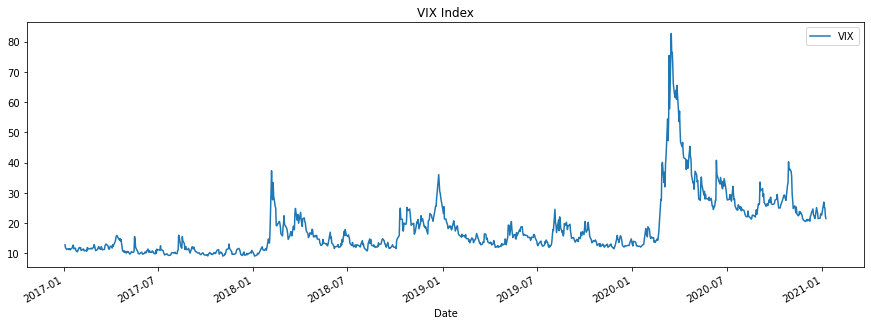

In [3]:
_finance_data.plot(y=['VIX'],use_index=True, figsize=(15,5),title="VIX Index")

In our project, we will set 2020-01-22 as the beginning of covid-19.The graph shows that:
* Before covid-19,, VIX did not fluctuate greatly.
* After covid-19 broke out, espically in the fisrt several months, VIX raised rapidly and reached a peak, which may not be consistent with the assumption that the volatility is time-invariant.

Then, our group researched on the volatility index of India, Hong Kong,Japan and Eurozone(Actually, it may be a great pity that there is no VIX index in the mainland of China, so we replace it with Hong Kong as it is one of the most important financial centers in the world and its market is closedly related to the mainland's).We downloaded those datas from Google and here are the datas:

In [4]:
IDVIX = pd.read_csv("IDIndex.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'IDVIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

IDVIX.index = IDVIX.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%d-%b-%y'))
finance_data = _finance_data.merge(IDVIX, left_index=True, right_index=True)
finance_data.head(2)

FileNotFoundError: [Errno 2] No such file or directory: 'IDIndex.csv'

In [ ]:
VHSI = pd.read_csv("VHSI.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'VHSI'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

VHSI.index = VHSI.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%d-%b-%y'))
finance_data = finance_data.merge(VHSI, left_index=True, right_index=True)
finance_data.head(2)

In [ ]:
JPVIX = pd.read_csv("JPIndex.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'JPVIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

JPVIX.index = JPVIX.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%Y.%m.%d'))
finance_data = finance_data.merge(JPVIX, left_index=True, right_index=True)
finance_data.head(2) 

In [ ]:
EUVIX = pd.read_csv("EUIndex.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'EUVIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

EUVIX.index = EUVIX.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%m/%d/%Y'))
finance_data = finance_data.merge(EUVIX, left_index=True, right_index=True)
finance_data.head(2) 

After collecting the datas, we plot them on the graph:

In [ ]:
Finance2=finance_data.drop(columns=['SP500'])

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
fig.delaxes(ax[2,1])
ax[0, 0].set_title('VIX',fontsize=20)
ax[0, 0].plot(Finance2.index, Finance2.VIX)
ax[1, 0].set_title('IDVIX',fontsize=20)
ax[1, 0].plot(Finance2.index, Finance2.IDVIX)
ax[2, 0].set_title('VHSI',fontsize=20)
ax[2, 0].plot(Finance2.index, Finance2.VHSI)
ax[0, 1].set_title('JPVIX',fontsize=20,)
ax[0, 1].plot(Finance2.index, Finance2.JPVIX)
ax[1, 1].set_title('EUVIX',fontsize=20)
ax[1, 1].plot(Finance2.index, Finance2.EUVIX)
plt.tight_layout()

According the the graph, all indices have a great peak after covid-19.(And maybe we can notice that the financial market of Japan is much more stable than that of other financial market).

In conclusion, obviously, the vix indices of these financial market reached a great peak after the broke up of covid-19, which may be a great challenge of "time-invariant volatility" consumption. To get more details of it, we will add the data of covid-19 into our research:

## Data with covid-19

We download the data of covid-19 from Johns Hopkins Coronavirus Resource Center.By using the methods learned from our classes, we merged these data to a total dataset of all countries and regions we researched on:

In [ ]:
_covid_19 =pd.read_csv(os.path.join(os.curdir, "covid.csv"))


covid_19 = _covid_19.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
        
covid_19['global'] = covid_19.apply('sum', axis=1)

# calculate the cases growth in each country
covid_19_country = pd.DataFrame(index=covid_19.index)
for country in covid_19.columns.unique():
        covid_19_country['cases_growth_' + country] = np.log(covid_19[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)                                  


# # calculate the cases growth in US
# covid_19['cases_growth_US'] = np.log(covid_19['US']).diff().rolling(14, win_type='gaussian').mean(std=3)


# calculate the cases growth globally
covid_19_country['cases_growth_global'] = covid_19_country.mean(axis=1)

covid_19_data = covid_19[['US', 'global']].merge(covid_19_country[['cases_growth_US', 
                                                                   'cases_growth_global', 
                                                                   'cases_growth_India',
                                                                   'cases_growth_Japan']], 
                                                 left_index=True, right_index=True)
covid_19_data=covid_19_data.drop(columns=['US','global'])

In [ ]:
_covid_19HK =pd.read_csv(os.path.join(os.curdir, "HKcovid.csv"))
covid_19HK = _covid_19HK.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
covid_19_HK= np.array(np.log(covid_19HK[['Hong Kong']].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3))       
covid_19HK['cases_growth_HK']=covid_19_HK

In [ ]:
covid_19_data=covid_19_data.merge(covid_19HK,left_index=True, right_index=True)
covid_19_data=covid_19_data.drop(columns=['Hong Kong'])

In [ ]:
_covid_19EU =pd.read_csv(os.path.join(os.curdir, "EUcovid.csv"))


covid_19EU = _covid_19EU.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
        
covid_19EU['EU'] = covid_19EU.apply('sum', axis=1)

# calculate the cases growth in each country in Eurozone
covid_19_EUcountry = pd.DataFrame(index=covid_19EU.index)
for country in covid_19EU.columns.unique():
        covid_19_EUcountry['cases_growth_' + country] = np.log(covid_19EU[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)                                  


covid_19_EUcountry['cases_growth_EU'] = covid_19_EUcountry.mean(axis=1)

In [ ]:
covid_19_data=covid_19_data.merge(covid_19_EUcountry['cases_growth_EU'],left_index=True, right_index=True)

In [ ]:
covid_19_data=covid_19_data.drop(index=['Unnamed: 0'])
covid_19_data=covid_19_data.fillna(0)

After doing these, we start to combine them with the VIX data:

In [ ]:
Finance_data=finance_data
Covid_19_data=covid_19_data
data = Finance_data.merge(Covid_19_data, left_index=True, right_index=True)
data.tail(3)

Firsrly, we show the covid datas of all countries and regions we researched on:

In [ ]:
data2=data[['cases_growth_global','cases_growth_US','cases_growth_India','cases_growth_Japan','cases_growth_HK','cases_growth_EU']]
data2.index.name='Date'
data2.columns.name='Cases_growth'

In [ ]:
fig,axs=plt.subplots(3,2,figsize=(20,8))

data2.plot(ax=axs,subplots=True,legend=False)
axs[0][0].set_title('Cases_growth_global')
axs[0][0].set_xlabel('')
axs[0][0].tick_params(labelbottom=False)
axs[0][1].set_title('Cases_growth_US')
axs[0][1].set_xlabel('')
axs[0][1].tick_params(labelbottom=False)
axs[1][0].set_title('Cases_growth_India')
axs[1][0].set_xlabel('')
axs[1][0].tick_params(labelbottom=False)
axs[1][1].set_title('Cases_growth_Japan')
axs[1][1].set_xlabel('')
axs[1][1].tick_params(labelbottom=False)
axs[2][0].set_title('Cases_growth_HK')
axs[2][1].set_title('Cases_growth_EU')


Then, we will draw the covid data and the volatility data of each country or region(the later one will be drawn **with black dotted line** separately. And in each graph we will also draw the graph of the global covid data.

Here is the situation of VIX in the United States:

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.VIX, 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("VIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_US'], label="US")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("VIX")
plt.legend()
plt.show()

Here is the situation of IDVIX in India:

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.IDVIX, 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("IDVIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_India'], label="India")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_India'], label='India')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("IDVIX")
plt.legend()
plt.show()

Here is the situation of JPVIX in Japan:

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index,data.JPVIX , 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("JPVIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_Japan'], label="Japan")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_Japan'], label='Japan')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title('JPVIX')
plt.legend()
plt.show()

Here is the situation of VHSI in Hong Kong:

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index,data.VHSI , 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("VHSI", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_HK'], label="Hong Kong")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_HK'], label='Hong Kong')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title('VHSI')
plt.legend()
plt.show()

Here is the situation of EUVIX in Eurozone:

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index,data.EUVIX , 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("EUVIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_EU'], label="EU")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_EU'], label='EU')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("EUVIX")
plt.legend()
plt.show()

From all things above, we can learn something interesting:
* The growth of confirmed cases of all these countries/regions rise to a peak between March and April.Although Japan did not has a "peak period", its growth on confirmed rates between March and April is also greater than that of other period.
* With the growth of confirmed cases, these countries/regions volitility also rise to a peak almost in a simultaneous way.Japan may be a little different from that of others(Its volitility is much lower than others as we have shown),but the time between its "covid peak" and "VIX peak" is also very closed.
* All these volitilites rise to the peak almost at the same time as that of Global confirmed rate. Maybe it demonstrate that the financial markets in the world are connected closedly and the volitility may greatly depend on the global situation.